In [1]:
import os
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import copy

In [3]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services import get_xml
from src.services import main
from services.preprocess import prepocess_pdf_rgions
from services.get_tables import page_num_correction , get_text_table_line_df

from utilities.xml_utils import (extract_image_paths_from_pdf,
                                 extract_xml_from_digital_pdf,
                                 extract_html_bg_images_from_digital_pdf,
                                 create_directory,
                                 read_directory_files)
import config

In [4]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of the program

In [40]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data', 'input')
save_dir = os.path.join(base_dir, 'sample-data', 'bbox_output')

output_dir = os.path.join(base_dir, 'sample-data', 'output')
create_directory(input_dir)
create_directory(output_dir)

filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'


## extract the pdf into xml & background images for downstream processing

In [41]:
pdf_filepath      = os.path.join(input_dir, filename)
working_dir       = os.path.join(output_dir, os.path.splitext(filename)[0])

ret               = create_directory(working_dir)

start_time        = time.time()

pdf_image_paths   = extract_image_paths_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir       = extract_xml_from_digital_pdf(pdf_filepath, working_dir)
pdf_bg_image_dir  = extract_html_bg_images_from_digital_pdf(pdf_filepath, working_dir)

end_time          = time.time()
extraction_time   = end_time - start_time

In [42]:
xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
bg_files       = read_directory_files(pdf_bg_image_dir, pattern='*.png')

print("Extracted xml, background images & images of file: %s" % (filename))
print('Extraction time (%f) average extraction time (%f)' % (extraction_time, extraction_time/len(bg_files)))

Extracted xml, background images & images of file: 20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf
Extraction time (6.175267) average extraction time (0.114357)


In [43]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])
img_dfs, page_width, page_height = get_xml_image_info(xml_files[0])


Total number of pages (54) in file (20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml)
Total number of pages (54) in file (20695_2010_8_1501_20635_Judgement_17-Feb-2020.xml)


In [161]:
page_index      = 3

img_filepath    = pdf_image_paths[page_index]
bg_img_filepath = bg_files[page_index]
df              = xml_dfs[page_index]
img_df          = img_dfs[page_index]


# Draw Bounding box using v_df

In [101]:
def draw_vdf(xml_dfs,img_dfs,image_files,page_height,file_name,file_index):
    multiple_pages = False
    if len(xml_dfs) > 1:
        multiple_pages =True
    header_region, footer_region = prepocess_pdf_rgions(xml_dfs, page_height)
    img_df = img_dfs[file_index]
    table_image = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
    #in_df, table_df, line_df = get_text_table_line_df(table_image, xml_dfs[file_index])
    in_df = xml_dfs[file_index]
    v_df = get_xml.get_vdf(in_df, image_files, config.DOCUMENT_CONFIGS, file_index,header_region , footer_region, multiple_pages)

    return v_df


In [102]:
v_df = draw_vdf(xml_dfs,img_dfs,bg_files,page_height,filename,page_index)

/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/serv

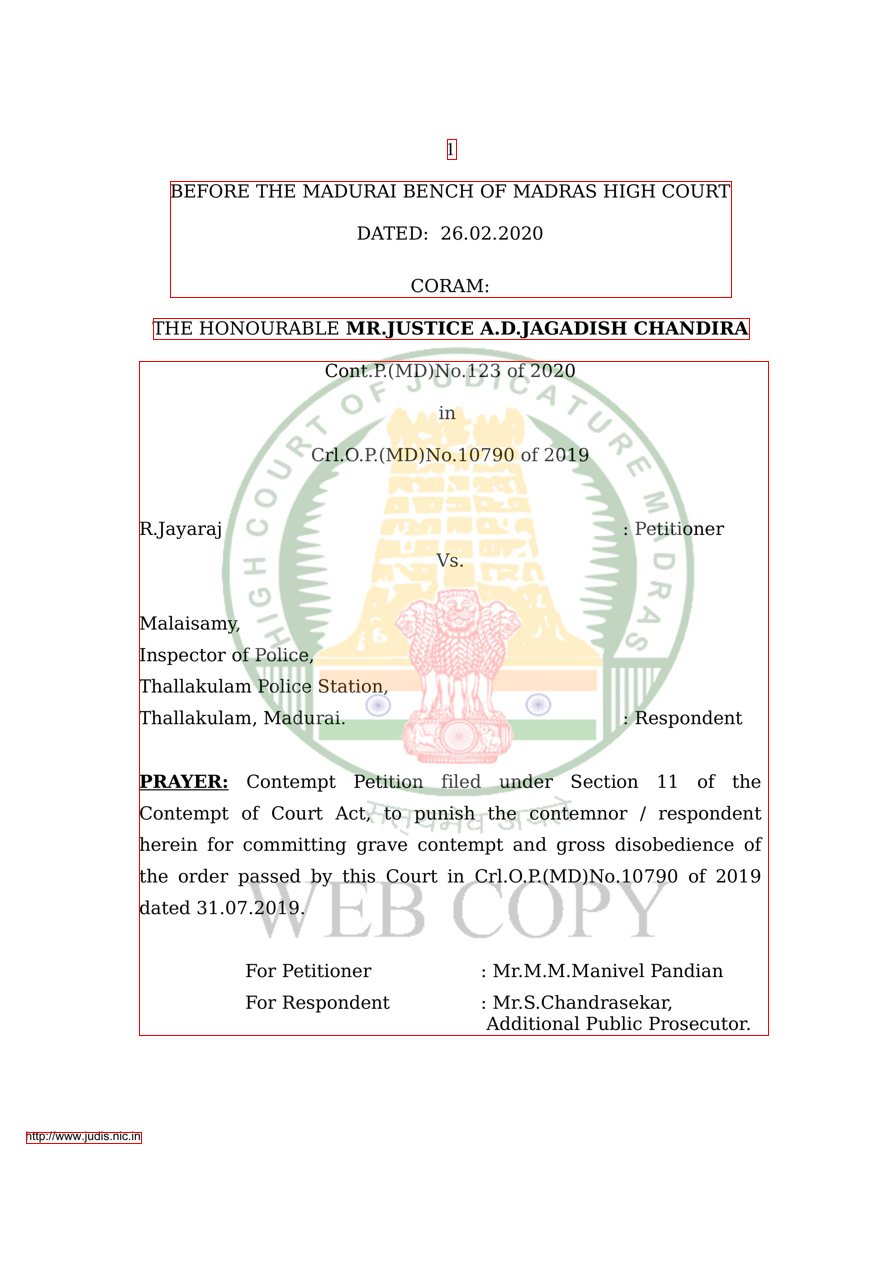

In [103]:
draw_box(img_filepath, page_width, page_height, v_df, color='red')

# Draw bounding box using p_df

In [235]:
def draw_pdf(xml_dfs,img_dfs,image_files,page_height,file_name,file_index):
    
    multiple_pages = False
    if len(xml_dfs) > 1:
        multiple_pages =True
    header_region, footer_region = prepocess_pdf_rgions(xml_dfs, page_height)
    img_df = img_dfs[file_index]
    #table_image = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
    in_df = xml_dfs[file_index]
    v_df = get_xml.get_vdf(in_df, image_files, config.DOCUMENT_CONFIGS, file_index,header_region , footer_region, multiple_pages)
    p_df = main.process_page_blocks(v_df, config.DOCUMENT_CONFIGS, config.BLOCK_CONFIGS)
    p_df = p_df.reset_index(drop=True)
    return p_df


In [236]:
p_df = draw_pdf(xml_dfs,img_dfs,bg_files,page_height,filename,page_index)

/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/serv

In [237]:
draw_box(img_filepath, page_width, page_height, p_df, color='red')

TypeError: draw_box() got an unexpected keyword argument 'color'

# Draw bounding box for json response 

In [107]:
from src.services import main

In [108]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(pdf_path)

Total number of pages (4) in file (Madras_HC_02.xml)
Total number of pages (4) in file (Madras_HC_02.xml)


/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/serv

In [109]:
def draw_box(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        for block in page_data['blocks']:
            top     = block["text_top"];         left   = block["text_left"];  
            bottom  = top+block["text_height"];  right  = left+block["text_width"]
            draw.rectangle(((left, top), (right,bottom)), outline='red')
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [110]:
draw_box(data,pdf_image_paths,save_path)

In [115]:
from services.service import BlockMerging
block_merger = BlockMerging()


In [162]:
def draw_pdf(xml_dfs,img_dfs,image_files,page_height,file_name,file_index):
    
    multiple_pages = False
    if len(xml_dfs) > 1:
        multiple_pages =True
    header_region, footer_region = prepocess_pdf_rgions(xml_dfs, page_height)
    img_df = img_dfs[file_index]
    #table_image = working_dir + '/' + page_num_correction(file_index , 3) + '.png'
    in_df = xml_dfs[file_index]
    v_df = get_xml.get_vdf(in_df, image_files, config.DOCUMENT_CONFIGS, file_index,header_region , footer_region, multiple_pages)
    p_df = main.process_page_blocks(v_df, config.DOCUMENT_CONFIGS, config.BLOCK_CONFIGS)
    p_df = p_df.reset_index(drop=True)
    
    #output_data = block_merger.merge_blocks(p_df)

    return p_df


In [163]:
p_df = draw_pdf(xml_dfs,img_dfs,bg_files,page_height,filename,page_index)

/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/services/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height']


In [164]:
p_df

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,children,level_0
0,0,0,56,730,58,14,PART A,14,Arial,#000000,,None,NaN
1,NaN,2,112,108,682,103,This notification was to remain in force for a...,18,Arial,#000000,NaN,"{""level_0"":{""0"":1,""1"":2,""2"":3},""index"":{""0"":1,...",NaN
2,NaN,5,258,108,682,65,4. By a notification 5 dated 31 Decembe...,18,Arial,#000000,NaN,"{""level_0"":{""3"":4,""4"":5},""index"":{""3"":4,""4"":5}...",NaN
3,NaN,10,345,216,198,60,"“(i) Corps of Signals, (ii) Intelligence Co...",15,Arial,#000000,NaN,"{""level_0"":{""0"":6,""1"":7,""2"":8},""index"":{""0"":6,...",NaN
4,NaN,16,411,216,394,36,(iv) Corps of Electrical and Mechanical Engin...,15,Arial,#000000,NaN,"{""level_0"":{""3"":9,""4"":10},""index"":{""3"":9,""4"":1...",NaN
5,NaN,20,496,108,682,147,5. The provision for the induction of women ...,18,Arial,#000000,NaN,"{""level_0"":{""0"":11,""1"":12,""2"":13,""3"":14},""inde...",NaN
6,NaN,29,686,108,682,151,"6. On 28 October 2005, a notification 8 was...",18,Arial,#000000,NaN,"{""level_0"":{""4"":15,""5"":16,""6"":17,""7"":18},""inde...",NaN
7,NaN,38,863,135,655,146,(i) The tenure of women officers inducted und...,18,Arial,#000000,NaN,"{""level_0"":{""8"":19,""9"":20,""10"":21,""11"":22},""in...",NaN
8,NaN,45,1077,108,330,31,"5 SRO-1, published in the Gazette on 23 Janua...",13,Arial,#000000,NaN,"{""level_0"":{""0"":23,""1"":24},""index"":{""0"":23,""1""...",NaN
9,NaN,49,1108,108,50,16,7 “MoD”,13,Arial,#000000,NaN,NaN,NaN


In [182]:
def drop_text_regards_attrib(attr,drop_lis):
    
    if attr in drop_lis:
        return True
    else:
        return False
    

In [183]:
def get_children_text(block,drop_lis):
    
        
        if block['children']==None:
            return block['text']
        else:
            text = ""
            block_children =  pd.read_json(block['children'])
            block_children = block_children.reset_index(drop=True)
            block_children  = block_children.where(block_children.notnull(), None)
            block_children= block_children.sort_values('text_top')

            for sub_block_index in range(len(block_children)):
                
                sub_df= block_children.iloc[sub_block_index]
                sub_df  = sub_df.where(sub_df.notnull(), None)
                if sub_df['children'] == None:
                    
                    text = text+" " + sub_df['text']
                    continue
                else:
                                
                    sub2_block_children =  pd.read_json(sub_df['children'])
                    
                    sub2_block_children = sub2_block_children.reset_index(drop=True)
                    sub2_block_children= sub2_block_children.sort_values('text_left')

                    for sub2_block_index in range(len(sub2_block_children)):
                        
                        if 'attrib' in sub2_block_children.columns:
                            
                            if drop_text_regards_attrib(sub2_block_children['attrib'][sub2_block_index],drop_lis):
                                continue
                            else:
                                text = text+" " + sub2_block_children['text'][sub2_block_index]
                        else:
                            text = text+" " + sub2_block_children['text'][sub2_block_index]
                            
                        
            return text

def get_block(data,drop_lis):
    
    for block_index in range(len(data)):
        df = data.iloc[block_index]
        df   = df.where(df.notnull(), None)
        text = get_children_text(df,drop_lis)
        data.iloc[block_index]['text'] = str(text)

    return data

def merge_blocks(in_data,drop_lis):
    #log.info("Block Merging started ===>")
    out_data = get_block(in_data,drop_lis)
    #log.info("Block Merging completed")
    return out_data

In [184]:
drop_lis = ['SUPERSCRIPT']
out_data = merge_blocks(p_df,drop_lis)

In [185]:
for i in out_data['text']:
    print("xxxxxxxxxxxxx",i)

xxxxxxxxxxxxx PART A 
xxxxxxxxxxxxx  This notification was to remain in force for a period of five years from the date on  which  it  was  published  in  the  official  Gazette.  SRO-11  was  published  in  the  Gazette on 15 February 1992.  
xxxxxxxxxxxxx  4.  By  a  notification   dated  31  December  1992,  women  became  eligible  for  enrollment in the following corps/departments of the regular Army:  
xxxxxxxxxxxxx  Corps of Signals,  (ii)  Intelligence Corps,  (iii)  Corps of Engineers, 
xxxxxxxxxxxxx  (iv)  Corps of Electrical and Mechanical Engineering,  (v) 
xxxxxxxxxxxxx  5.  The provision for  the induction of women for  an initial period of five  years  was extended by a notification  dated 12 December 1996 issued by the Ministry  of  Defence .  The  notification  deleted  paragraph  2  of  SRO-11  under  which  enrollment was to be for a period of five years.  
xxxxxxxxxxxxx  6.  On 28 October 2005,  a notification  was issued by  the  MoD by  which the  Union  Government

In [169]:
d = pd.read_json(p_df['children'][6])

In [170]:
p = d.reset_index(drop=True)

In [174]:
d1 = pd.read_json(p['children'][2])

In [175]:
d1

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib
0,0,35,777,108,159,17,women as officers,18,Arial,#000000,
1,1,36,773,269,520,21,"in the Indian Army”. To facilitate this, four ...",18,Arial,#000000,SUPERSCRIPT


In [157]:
p1 = p.sort_values('text_top')

In [158]:
p1

,level_0,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,children
0,20,20,34,901,216,334,18,(ii) Judge Advocate General‟s Department;,15,Arial,#000000,NaN,"{""index"":{""0"":0,""1"":1},""xml_index"":{""0"":34,""1""..."
1,21,21,36,925,216,220,15,(iii) Army Education Corps;,15,Arial,#000000,NaN,"{""index"":{""0"":0,""1"":1},""xml_index"":{""0"":36,""1""..."


In [160]:
d1

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib
0,0,34,904,216,26,15,(ii),15,Arial,#000000,
1,1,35,901,270,280,18,Judge Advocate General‟s Department;,15,Arial,#000000,SUPERSCRIPT


In [77]:
d2 = d1.sort_values('text_left')

In [78]:
d2

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib
0,0,6,220,108,112,17,Commissions,18,Arial,#000000,
1,1,7,215,221,7,11,1,12,Arial,#000000,SUPERSCRIPT
2,2,8,220,227,563,17,in the Indian Army forms the basis of...,18,Arial,#000000,


In [82]:
d2.loc[0]

index                    0
xml_index                6
text_top               220
text_left              108
text_width             112
text_height             17
text           Commissions
font_size               18
font_family          Arial
font_color         #000000
attrib                    
Name: 0, dtype: object